In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

In [2]:
# set period under observation
start_date = datetime(2022, 7, 1)
end_date = datetime(2024, 5, 31)
# end_date = datetime.today() - relativedelta(months=2)

## EDA

In [3]:
brent_oil_price = pd.read_csv('DCOILBRENTEU.csv')
brent_oil_price = brent_oil_price[(brent_oil_price['DATE'] >= str(start_date)) & (brent_oil_price['DATE'] <= str(end_date))]
brent_oil_price.set_index('DATE', inplace=True)
brent_oil_price.index.name='date'
brent_oil_price.head()

,DCOILBRENTEU
date,
2022-07-04,121.80
2022-07-05,110.49
2022-07-06,108.54
2022-07-07,113.40
2022-07-08,113.95


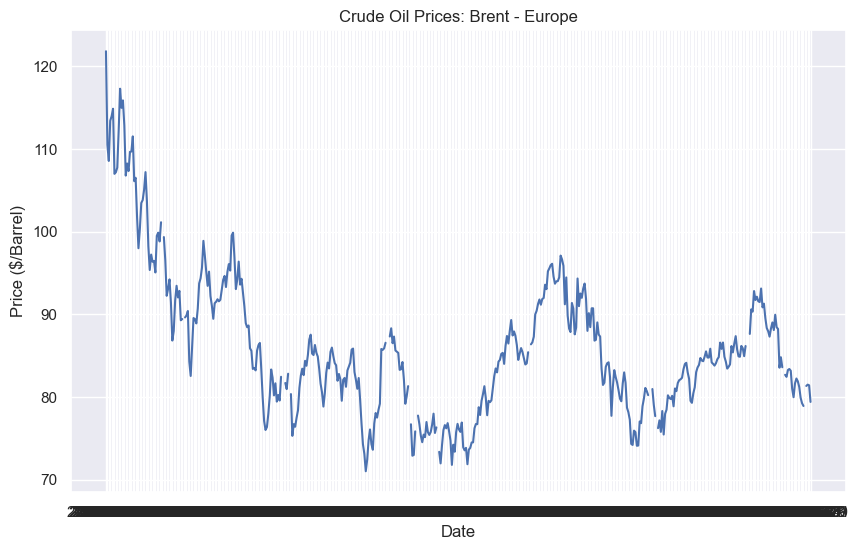

In [9]:
# Plotting
sns.set_theme()
plt.figure(figsize=(10, 6))
plt.plot(brent_oil_price)
plt.title('Crude Oil Prices: Brent - Europe')
plt.xlabel("Date")
plt.ylabel("Price ($/Barrel)")
plt.show()

In [11]:
tweets_sentiment = pd.read_csv('tweets_sentiment.csv', index_col='Unnamed: 0',  lineterminator='\n')
tweets_sentiment['sentiment_score'] = tweets_sentiment['Positive'] - tweets_sentiment['Negative']
tweets_sentiment['label'] = tweets_sentiment[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)\
                                .map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

tweets_topic = pd.read_csv('tweets_topic.csv', index_col='Unnamed: 0')

tweets_df = tweets_sentiment.merge(tweets_topic, how='inner', on='id', suffixes=('', '_copy'))
tweets_df.drop(columns=[col for col in tweets_df.columns if col.endswith('_copy')], inplace=True)
tweets_df = tweets_df[(tweets_df['date'] >= str(start_date)) & (tweets_df['date'] <= str(end_date))]
tweets_df.tail()

,id,date,lang,rawContent,user_id,username,displayname,rawDescription,Positive,Negative,Neutral,sentiment_score,label,topic
37685,1730343584572867060,2023-11-30,en,"At least based on today, can't say there's muc...",1209952412338991104,TheFortuneTell5,The Fortune Teller @ Wheel of Fortune,Market Beast 30+yrs\nInvestment/portfolio mana...,0.044599,0.062963,0.892437,-0.018364,0,3
37686,1730185032914829401,2023-11-30,en,"Is $XOM's ""Death Cross"" a reason for #Energy b...",1209952412338991104,TheFortuneTell5,The Fortune Teller @ Wheel of Fortune,Market Beast 30+yrs\nInvestment/portfolio mana...,0.053212,0.118022,0.828767,-0.064810,0,3
37687,1730352191548883361,2023-11-30,en,#OOTT #WTI As the #OPEC+ conspiracy collapsed ...,3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.311486,0.573089,0.115425,-0.261603,-1,0
37688,1730348517313466869,2023-11-30,en,#OOTT #WTI [W1]#OPEC+ got clubbed after its pa...,3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.025245,0.888074,0.086681,-0.862829,-1,0
37689,1730343562728944032,2023-11-30,en,"#OOTT #WTI ""For now, the outcome does not live...",3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.023566,0.911276,0.065159,-0.887710,-1,0


In [12]:
# Group by date and calculate average sentiment
daily_sentiment = tweets_df.loc[:, ['date', 'label', 'sentiment_score']]
daily_sentiment = daily_sentiment.groupby(['date']).mean()

daily_sentiment.columns = [f'{col}_0' for col in daily_sentiment.columns]
daily_sentiment.head()

,label_0,sentiment_score_0
date,,
2022-07-02,0.333333,0.212321
2022-07-03,-0.264706,-0.217177
2022-07-04,-0.160714,-0.123233
2022-07-05,-0.163934,-0.139811
2022-07-06,-0.191781,-0.177303


In [13]:
# Group by date and topic and calculate average sentiment
daily_topic_sentiment = tweets_df.loc[:, ['date', 'label','topic', 'sentiment_score']]
daily_topic_sentiment['topic'] = daily_topic_sentiment['topic']+1
daily_topic_sentiment = daily_topic_sentiment.groupby(['date', 'topic']).mean()

# Unstack 'topic' to become columns
daily_topic_sentiment = daily_topic_sentiment.unstack(level='topic')

# # Flatten the column MultiIndex resulting from unstack
# daily_topic_sentiment.columns = daily_topic_sentiment.columns.get_level_values(1) + 1
daily_topic_sentiment.columns = daily_topic_sentiment.columns.map('{0[0]}_{0[1]}'.format) 

print(daily_topic_sentiment.head())
print('% days with no tweets by topic')
print(round(daily_topic_sentiment.isna().sum() / len(daily_topic_sentiment) * 100, 2))

             label_1   label_2   label_3   label_4  sentiment_score_1  \
date                                                                    
2022-07-02  0.000000  0.000000  1.000000  1.000000          -0.070201   
2022-07-03 -0.333333 -0.190476 -0.333333 -0.214286          -0.283336   
2022-07-04 -0.095238 -0.187500 -0.375000 -0.090909          -0.129210   
2022-07-05 -0.250000 -0.090909  0.000000  0.000000          -0.233597   
2022-07-06 -0.204545 -0.375000  0.000000 -0.181818          -0.207250   

            sentiment_score_2  sentiment_score_3  sentiment_score_4  
date                                                                 
2022-07-02          -0.004047           0.648673           0.839905  
2022-07-03          -0.173141          -0.271328          -0.135003  
2022-07-04          -0.082532          -0.274846          -0.060758  
2022-07-05          -0.049497           0.061214          -0.010699  
2022-07-06          -0.270887           0.003687          -0.153988 

In [14]:
daily_sentiment = pd.concat([daily_sentiment, daily_topic_sentiment], axis=1)
daily_sentiment.head()

,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,
2022-07-02,0.333333,0.212321,0.000000,0.000000,1.000000,1.000000,-0.070201,-0.004047,0.648673,0.839905
2022-07-03,-0.264706,-0.217177,-0.333333,-0.190476,-0.333333,-0.214286,-0.283336,-0.173141,-0.271328,-0.135003
2022-07-04,-0.160714,-0.123233,-0.095238,-0.187500,-0.375000,-0.090909,-0.129210,-0.082532,-0.274846,-0.060758
2022-07-05,-0.163934,-0.139811,-0.250000,-0.090909,0.000000,0.000000,-0.233597,-0.049497,0.061214,-0.010699
2022-07-06,-0.191781,-0.177303,-0.204545,-0.375000,0.000000,-0.181818,-0.207250,-0.270887,0.003687,-0.153988


In [15]:
features_df = daily_sentiment.fillna(0)
features_df = features_df.rolling(window=14).mean()
features_df.tail()

,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,
2024-05-27,-0.131565,-0.095001,-0.131330,-0.067803,-0.131790,-0.070437,-0.124900,-0.039582,-0.076256,-0.035031
2024-05-28,-0.107963,-0.080733,-0.097996,-0.032089,-0.138933,-0.070437,-0.104143,-0.018314,-0.084528,-0.032812
2024-05-29,-0.109261,-0.081775,-0.108201,-0.034356,-0.135292,-0.063294,-0.115152,-0.011972,-0.077494,-0.036426
2024-05-30,-0.116852,-0.089383,-0.136262,-0.018483,-0.145251,-0.053090,-0.136056,-0.010182,-0.083478,-0.028087
2024-05-31,-0.133805,-0.103338,-0.182393,-0.008364,-0.160727,-0.058447,-0.176806,-0.003806,-0.091201,-0.025401


In [16]:
df = pd.merge(brent_oil_price, features_df, left_index=True, right_index=True)
df.dropna(inplace=True)
df.head()

,DCOILBRENTEU,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,,
2022-07-15,112.26,-0.100718,-0.094681,-0.126855,-0.159596,-0.020181,-0.009720,-0.141888,-0.115794,-0.024170,-0.000075
2022-07-18,117.27,-0.113984,-0.102464,-0.138474,-0.141736,-0.073371,-0.054045,-0.140616,-0.104680,-0.067639,-0.039938
2022-07-19,114.96,-0.105730,-0.095613,-0.138474,-0.130481,-0.077340,-0.038172,-0.133889,-0.097904,-0.075590,-0.036888
2022-07-20,115.86,-0.102945,-0.090575,-0.153625,-0.099231,-0.085276,-0.025185,-0.143198,-0.077642,-0.077482,-0.022720
2022-07-21,112.81,-0.102922,-0.089576,-0.153437,-0.089027,-0.081804,-0.030287,-0.141744,-0.071876,-0.079970,-0.020499


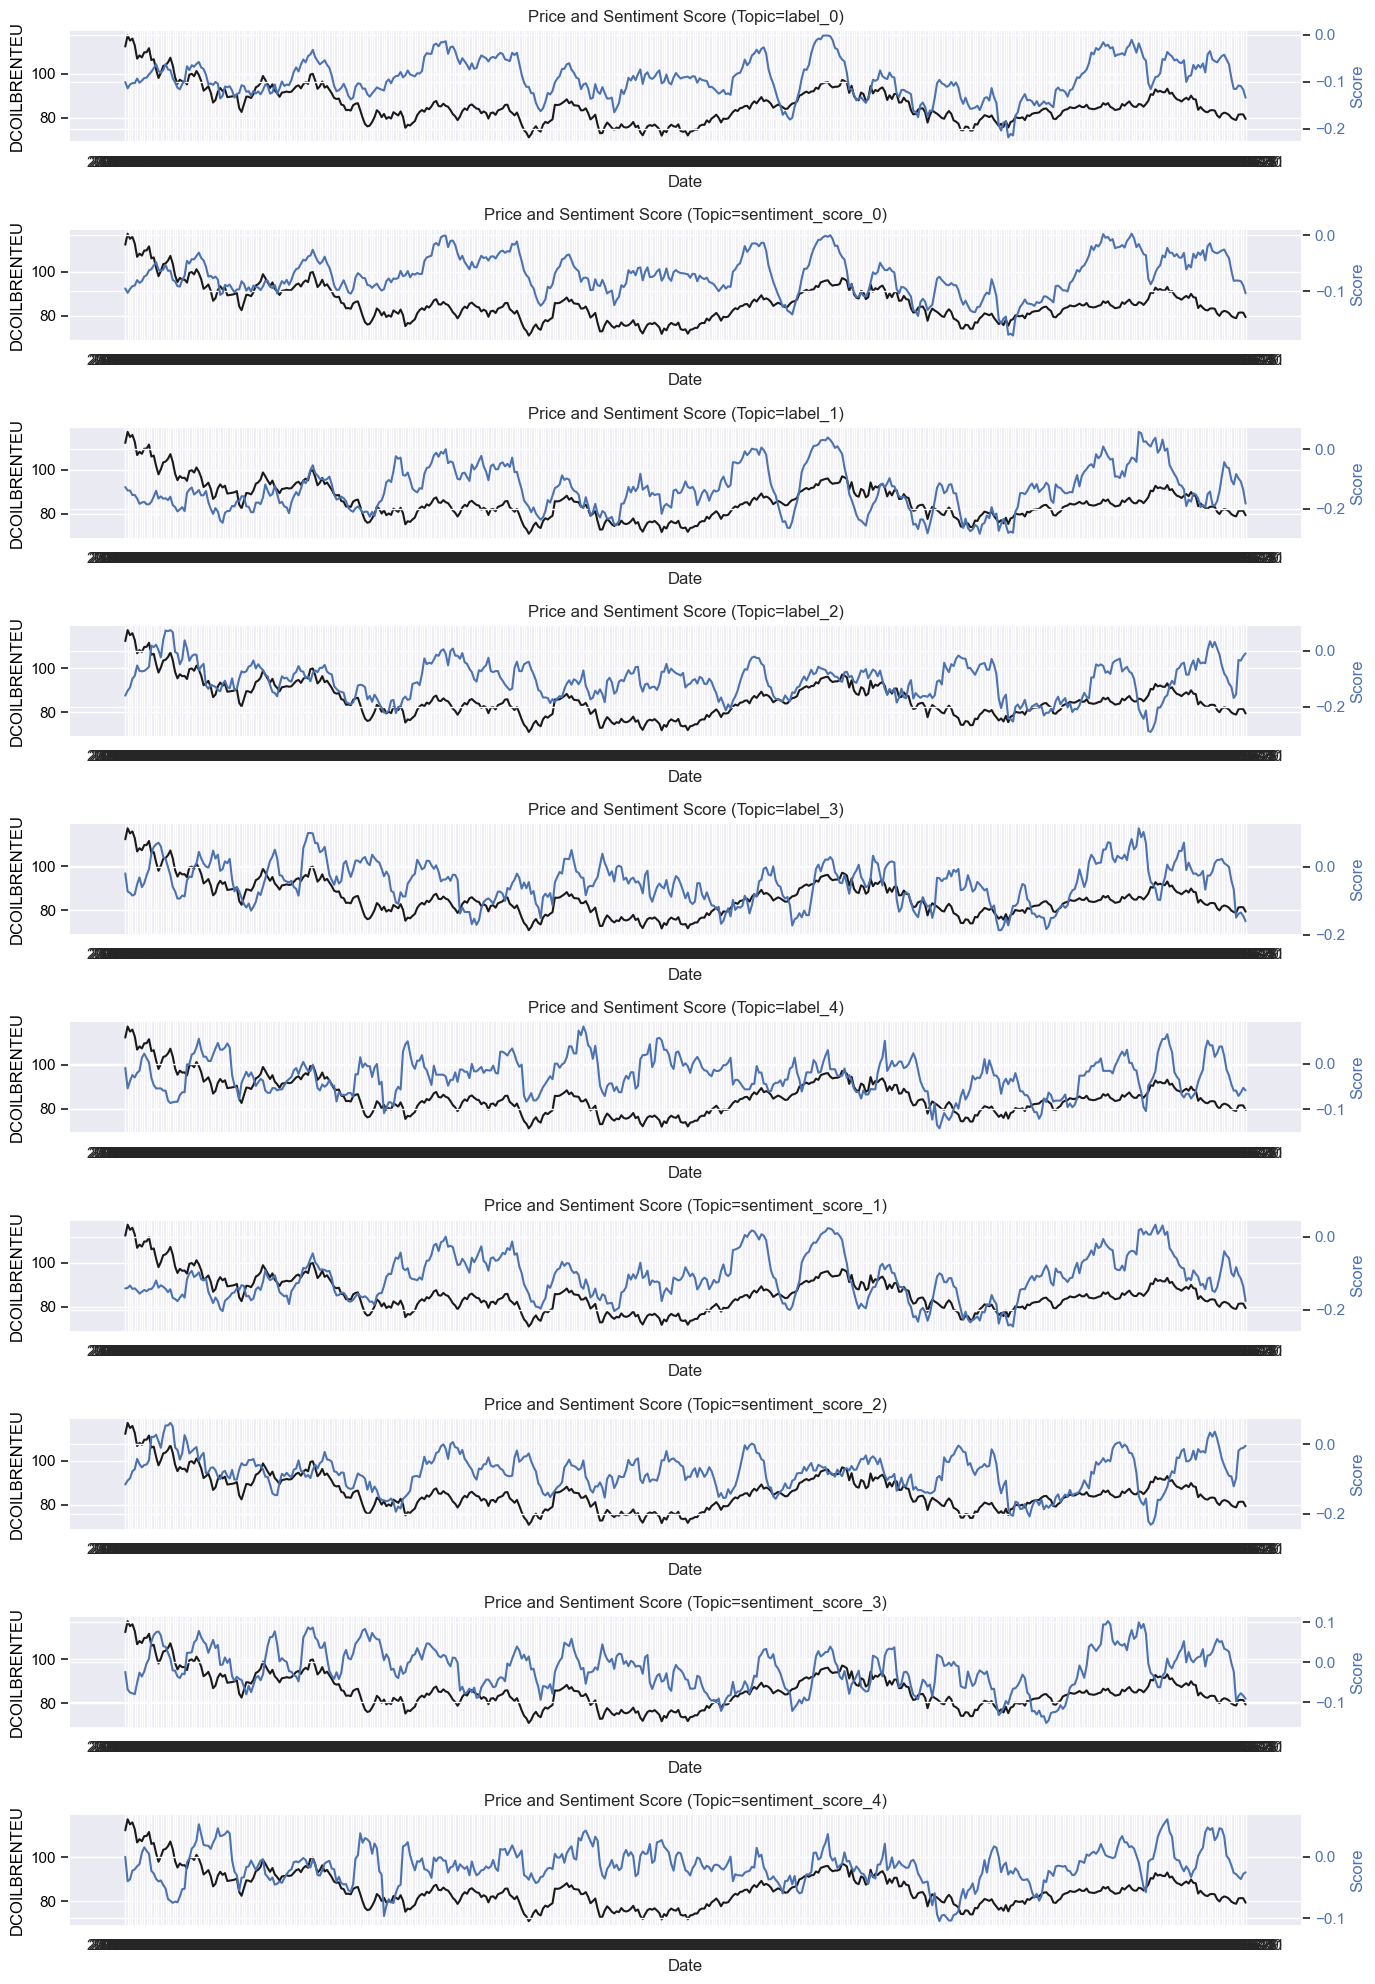

In [17]:
# Create subplots
fig, axs = plt.subplots(features_df.shape[1], 1, figsize=(14, 20))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each feature against the target on different y-axes
for i in range(1, df.shape[1]):
    col = df.columns[i]
    ax1 = axs[i-1]
    ax2 = ax1.twinx()
    
    ax1.plot(df['DCOILBRENTEU'], 'k-', label='Price')
    ax2.plot(df[col], 'b-', label=f'Topic {col}')
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('DCOILBRENTEU', color='black')
    ax2.set_ylabel('Score', color='b')
    
    ax1.tick_params(axis='y', labelcolor='black')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # ax1.legend(loc='upper left')
    # ax2.legend(loc='upper right')
    ax1.set_title(f'Price and Sentiment Score (Topic={col})')

# Adjust layout
plt.tight_layout()
plt.show()

## Stationarity Check

In [18]:
# Define helper function to check for stationarity
def check_stationarity(df, column, lags):
    # Drop NAs if any
    # df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=column)
    df = df.dropna(subset=column)

    plot_acf(df[column], lags=lags)
    plt.title(f"Autocorrelation Function (ACF) - {column}")
    plt.xlabel("Lags")
    plt.ylabel("ACF Value")
    plt.show()

    adftest = adfuller(df[column], maxlag=lags, autolag='AIC', regression='ct')
    if adftest[1] < 0.05:
        print("ADF Test Conclusion: Stationary")
    else:
        print("ADF Test Conclusion: Non-stationary")
    print("------------------------------------")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")
    
    return 

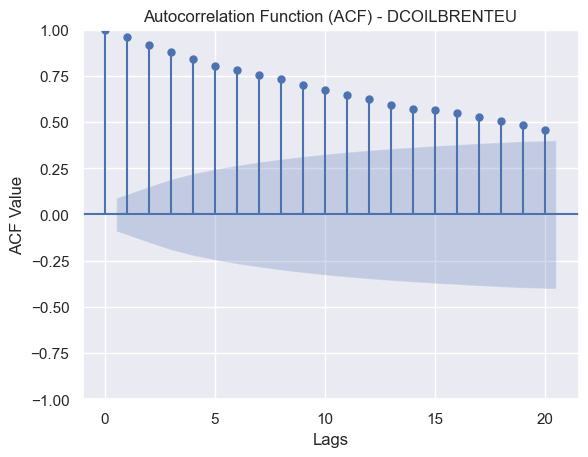

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.5601247235558904
P-Value: 0.2985817948656025
Number of lags: 14
Number of observations: 458
Critical Values: {'1%': -3.9786735140197895, '5%': -3.420119575474671, '10%': -3.1327143593020197}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [19]:
check_stationarity(df, 'DCOILBRENTEU', 20)

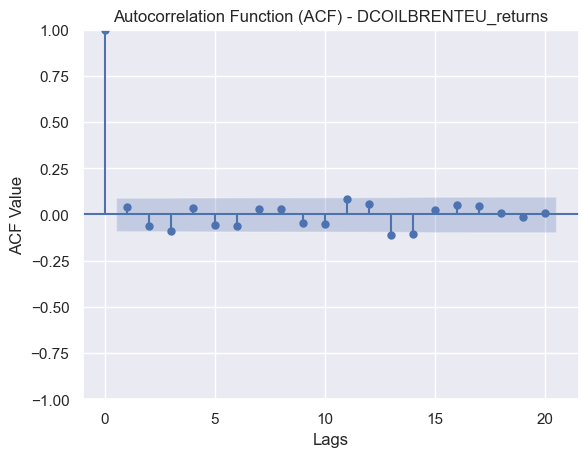

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -11.247037585918612
P-Value: 7.690502319981023e-18
Number of lags: 3
Number of observations: 468
Critical Values: {'1%': -3.978245333552409, '5%': -3.4199128949932036, '10%': -3.132592925069914}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [20]:
# Calculate first differences
df['DCOILBRENTEU_returns'] = df['DCOILBRENTEU'].pct_change(1)
check_stationarity(df, 'DCOILBRENTEU_returns', 20)

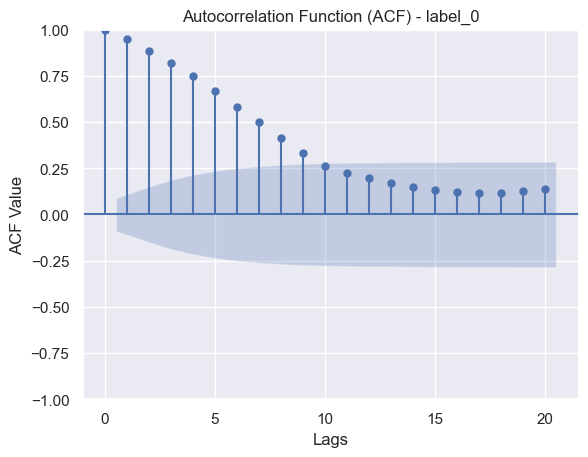

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -3.457355663209109
P-Value: 0.0441832592982014
Number of lags: 10
Number of observations: 462
Critical Values: {'1%': -3.978500002149453, '5%': -3.420035824722743, '10%': -3.1326651526468696}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


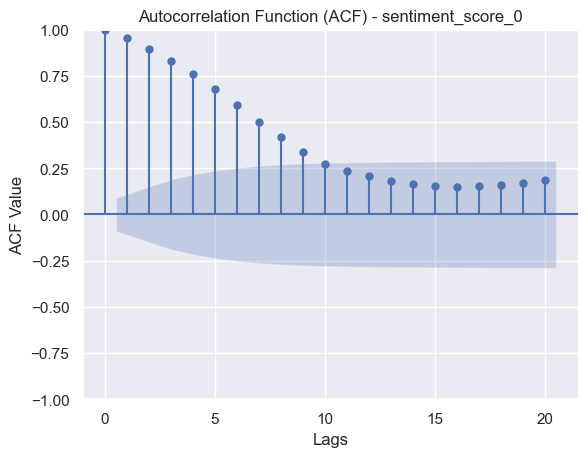

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -3.3173484459251354
P-Value: 0.06344978865730799
Number of lags: 10
Number of observations: 462
Critical Values: {'1%': -3.978500002149453, '5%': -3.420035824722743, '10%': -3.1326651526468696}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


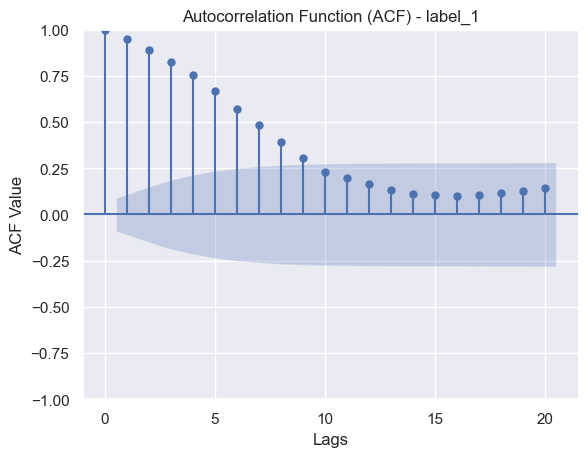

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.434916834235474
P-Value: 0.3612269195147483
Number of lags: 20
Number of observations: 452
Critical Values: {'1%': -3.9789395806401116, '5%': -3.4202479938961337, '10%': -3.132789807900356}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


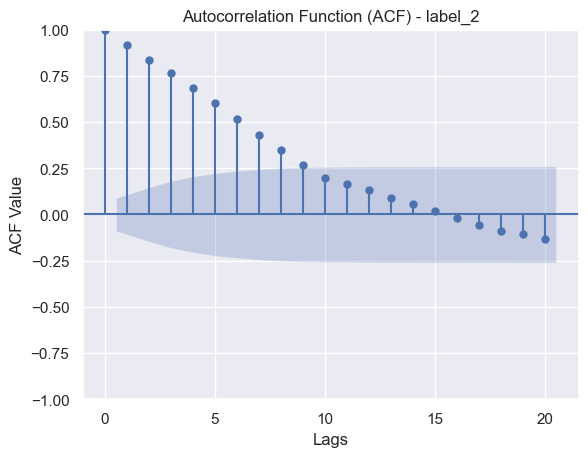

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.898717686516682
P-Value: 0.0003133503904449557
Number of lags: 15
Number of observations: 457
Critical Values: {'1%': -3.9787173698978626, '5%': -3.4201407432961233, '10%': -3.1327267960179537}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


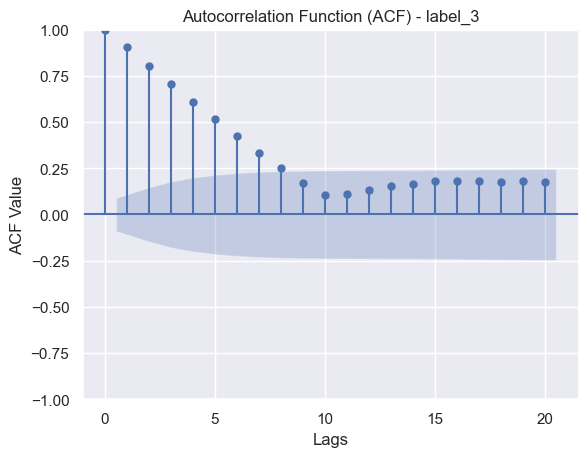

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -3.0534897001898837
P-Value: 0.11773487795888837
Number of lags: 20
Number of observations: 452
Critical Values: {'1%': -3.9789395806401116, '5%': -3.4202479938961337, '10%': -3.132789807900356}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


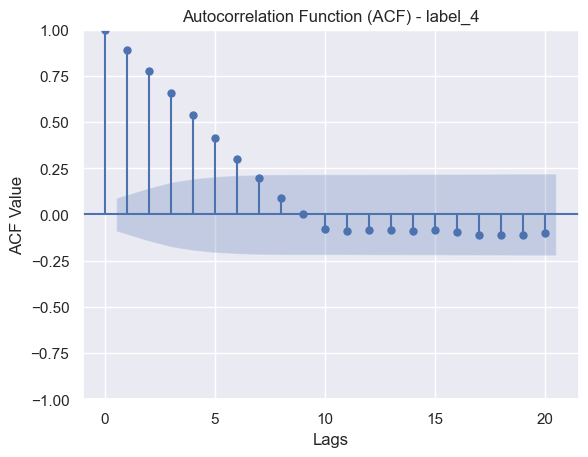

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.79390551508474
P-Value: 0.0004800381544630835
Number of lags: 10
Number of observations: 462
Critical Values: {'1%': -3.978500002149453, '5%': -3.420035824722743, '10%': -3.1326651526468696}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


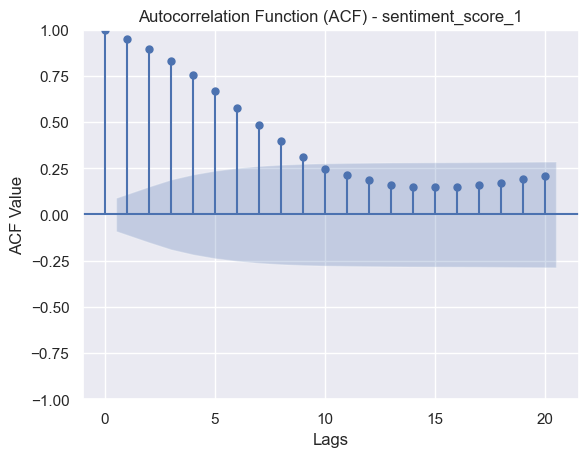

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.2765084186593434
P-Value: 0.44698470926260225
Number of lags: 20
Number of observations: 452
Critical Values: {'1%': -3.9789395806401116, '5%': -3.4202479938961337, '10%': -3.132789807900356}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


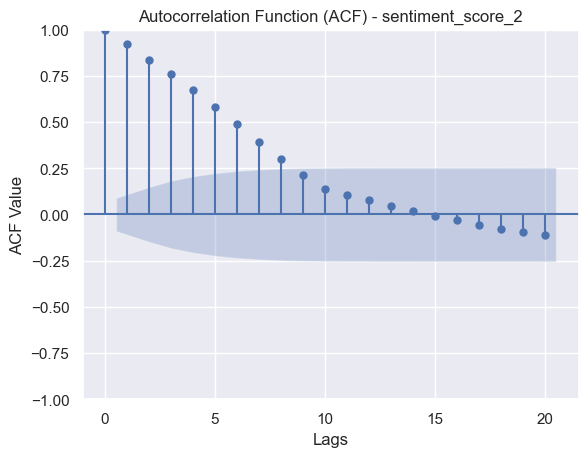

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.989282958660387
P-Value: 0.00021519568071391525
Number of lags: 16
Number of observations: 456
Critical Values: {'1%': -3.9787614194731136, '5%': -3.4201620043878207, '10%': -3.1327392874680067}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


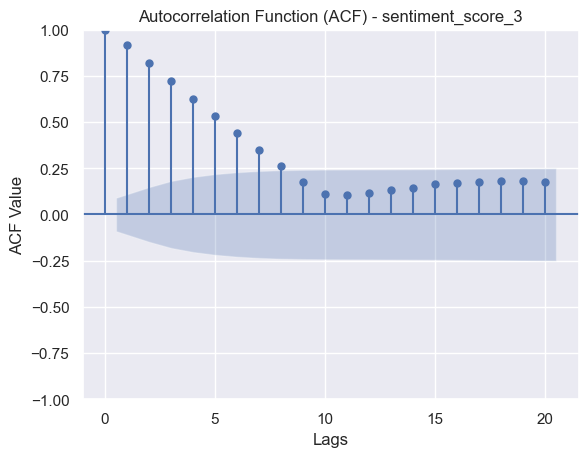

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -3.101609337567967
P-Value: 0.10584773266966957
Number of lags: 20
Number of observations: 452
Critical Values: {'1%': -3.9789395806401116, '5%': -3.4202479938961337, '10%': -3.132789807900356}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


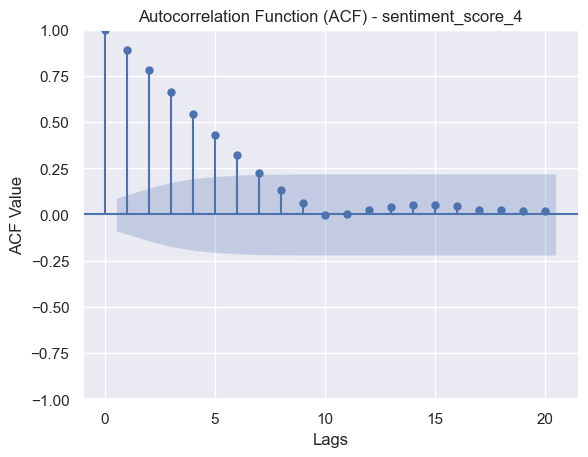

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.2504762591119505
P-Value: 0.0037514769371067894
Number of lags: 10
Number of observations: 462
Critical Values: {'1%': -3.978500002149453, '5%': -3.420035824722743, '10%': -3.1326651526468696}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [21]:
for col in features_df.columns:
    check_stationarity(df, col, 20)

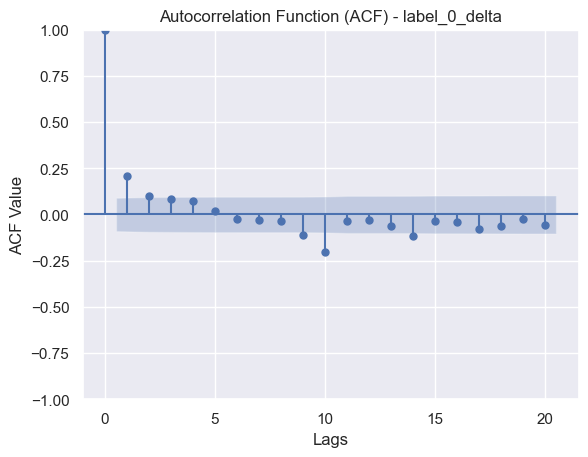

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -8.613810361627491
P-Value: 2.7494213573927504e-12
Number of lags: 9
Number of observations: 462
Critical Values: {'1%': -3.978500002149453, '5%': -3.420035824722743, '10%': -3.1326651526468696}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


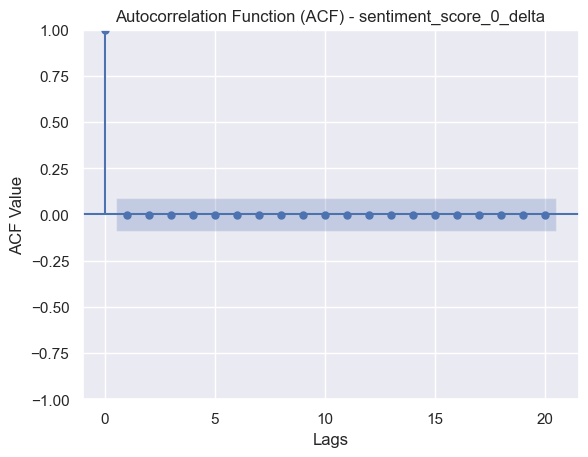

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -21.67910012900066
P-Value: 0.0
Number of lags: 0
Number of observations: 471
Critical Values: {'1%': -3.9781204488807234, '5%': -3.4198526098667803, '10%': -3.1325575036441577}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


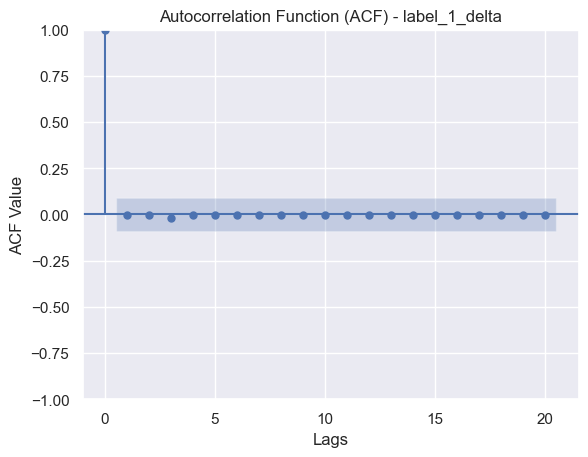

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -21.78778306303296
P-Value: 0.0
Number of lags: 0
Number of observations: 471
Critical Values: {'1%': -3.9781204488807234, '5%': -3.4198526098667803, '10%': -3.1325575036441577}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


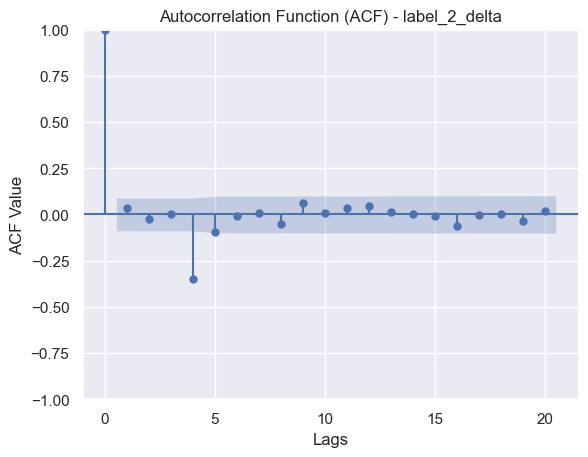

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -11.476556028243179
P-Value: 2.964026005171779e-18
Number of lags: 7
Number of observations: 464
Critical Values: {'1%': -3.978414375776397, '5%': -3.419994493296638, '10%': -3.1326408685380063}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


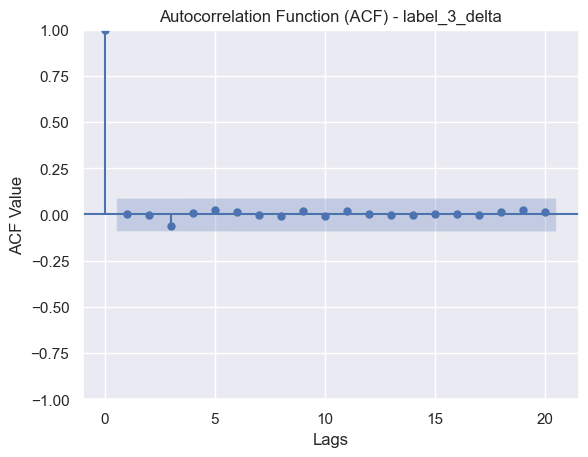

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -21.658081954973905
P-Value: 0.0
Number of lags: 0
Number of observations: 471
Critical Values: {'1%': -3.9781204488807234, '5%': -3.4198526098667803, '10%': -3.1325575036441577}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


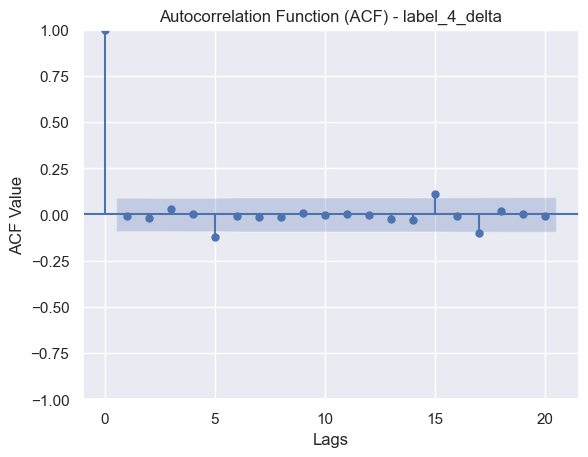

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -21.799648541739476
P-Value: 0.0
Number of lags: 0
Number of observations: 471
Critical Values: {'1%': -3.9781204488807234, '5%': -3.4198526098667803, '10%': -3.1325575036441577}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


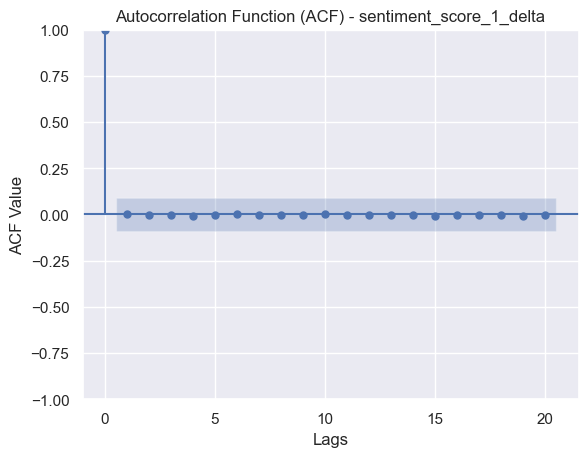

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -21.618312986686327
P-Value: 0.0
Number of lags: 0
Number of observations: 471
Critical Values: {'1%': -3.9781204488807234, '5%': -3.4198526098667803, '10%': -3.1325575036441577}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


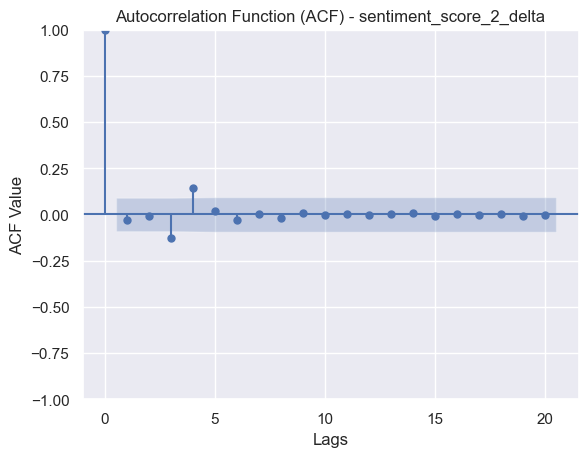

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -10.59197479844861
P-Value: 1.390446463997189e-16
Number of lags: 3
Number of observations: 468
Critical Values: {'1%': -3.978245333552409, '5%': -3.4199128949932036, '10%': -3.132592925069914}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


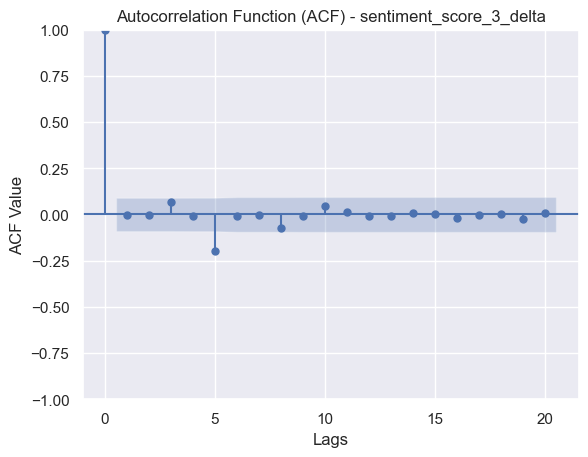

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -11.343700471698106
P-Value: 5.1261679316068326e-18
Number of lags: 4
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


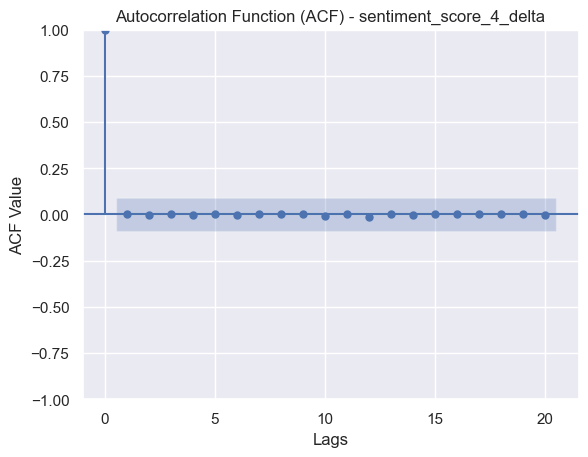

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -42.21418460447011
P-Value: 0.0
Number of lags: 0
Number of observations: 471
Critical Values: {'1%': -3.9781204488807234, '5%': -3.4198526098667803, '10%': -3.1325575036441577}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [22]:
for col in features_df.columns:
    new_column_name = f'{col}_delta'
    df[new_column_name] = df[col].pct_change(1)
    check_stationarity(df, new_column_name, 20)

## Granger Causality Check

In [23]:
def check_granger_causality(df, target, features, maxlag, test='ssr_chi2test'):
    granger_df = pd.DataFrame()
    granger_df['lag'] = [i for i in range(1,maxlag+1)]
    for feature in features:
        res = grangercausalitytests(df[[target, feature]], maxlag=maxlag)
        p_value = [res.get(i)[0].get(test)[1] for i in res.keys()]
        # for i in res.keys():
        #     p_value.append()
        col_name = f'{feature}_causes_{target}'
        granger_df[col_name] = p_value

    plt.figure(figsize=(16,9))
    for y in granger_df.columns[1:]:   
        plt.plot(granger_df['lag'],granger_df[y],linewidth=3, label=y)
    plt.axhline(0.05)
    # plt.axhline(0.10)
    plt.xlabel('lag')
    plt.legend()
    plt.show()




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0323  , p=0.8574  , df_denom=468, df_num=1
ssr based chi2 test:   chi2=0.0325  , p=0.8569  , df=1
likelihood ratio test: chi2=0.0325  , p=0.8569  , df=1
parameter F test:         F=0.0323  , p=0.8574  , df_denom=468, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0085  , p=0.9915  , df_denom=465, df_num=2
ssr based chi2 test:   chi2=0.0173  , p=0.9914  , df=2
likelihood ratio test: chi2=0.0173  , p=0.9914  , df=2
parameter F test:         F=0.0085  , p=0.9915  , df_denom=465, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0252  , p=0.9946  , df_denom=462, df_num=3
ssr based chi2 test:   chi2=0.0769  , p=0.9945  , df=3
likelihood ratio test: chi2=0.0769  , p=0.9945  , df=3
parameter F test:         F=0.0252  , p=0.9946  , df_denom=462, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4897  , p=0.7433  

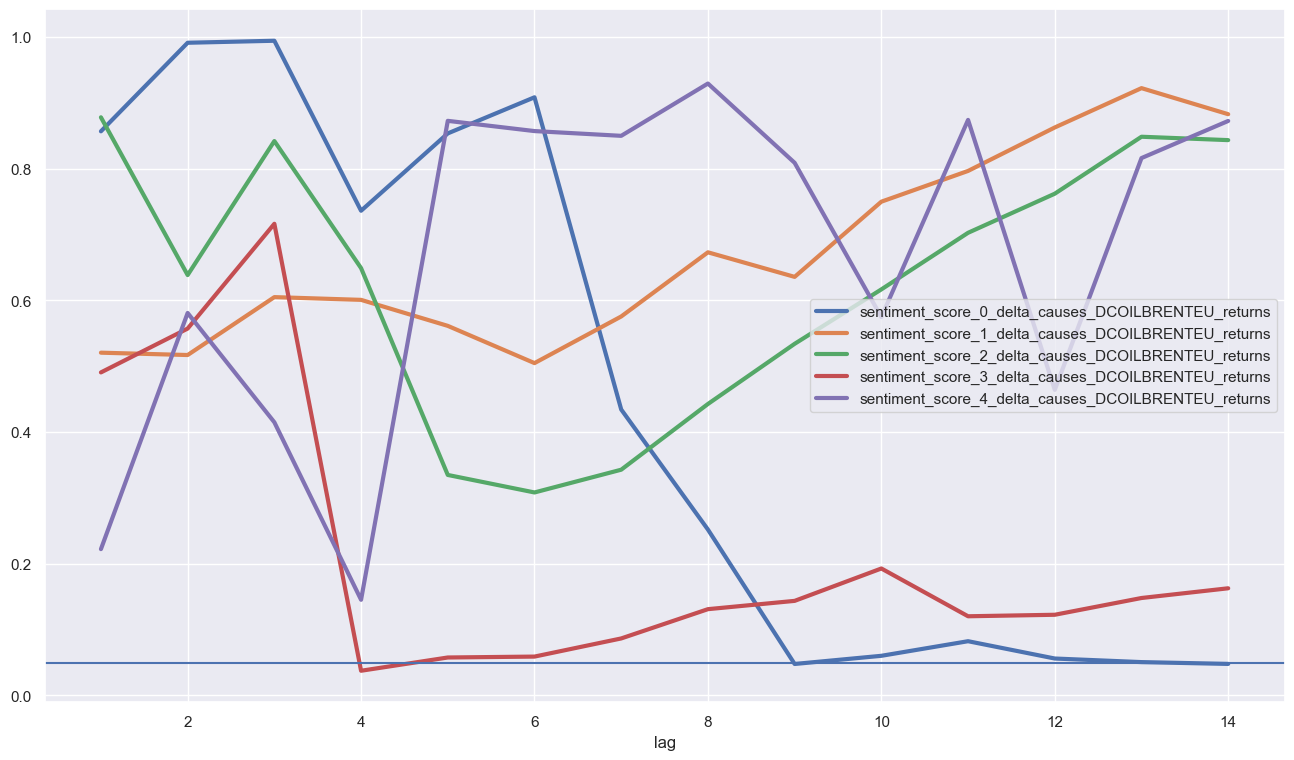

In [24]:
model_df = df.dropna()

selected_target = 'DCOILBRENTEU_returns'
selected_features = [f'{col}_delta' for col in features_df.columns if col.startswith('sentiment_score')]
# selected_features = features_df.columns

check_granger_causality(model_df, selected_target, selected_features, 14)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0014  , p=0.3175  , df_denom=468, df_num=1
ssr based chi2 test:   chi2=1.0078  , p=0.3154  , df=1
likelihood ratio test: chi2=1.0068  , p=0.3157  , df=1
parameter F test:         F=1.0014  , p=0.3175  , df_denom=468, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7891  , p=0.4548  , df_denom=465, df_num=2
ssr based chi2 test:   chi2=1.5953  , p=0.4504  , df=2
likelihood ratio test: chi2=1.5926  , p=0.4510  , df=2
parameter F test:         F=0.7891  , p=0.4548  , df_denom=465, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5138  , p=0.6729  , df_denom=462, df_num=3
ssr based chi2 test:   chi2=1.5648  , p=0.6674  , df=3
likelihood ratio test: chi2=1.5622  , p=0.6680  , df=3
parameter F test:         F=0.5138  , p=0.6729  , df_denom=462, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4809  , p=0.7498  

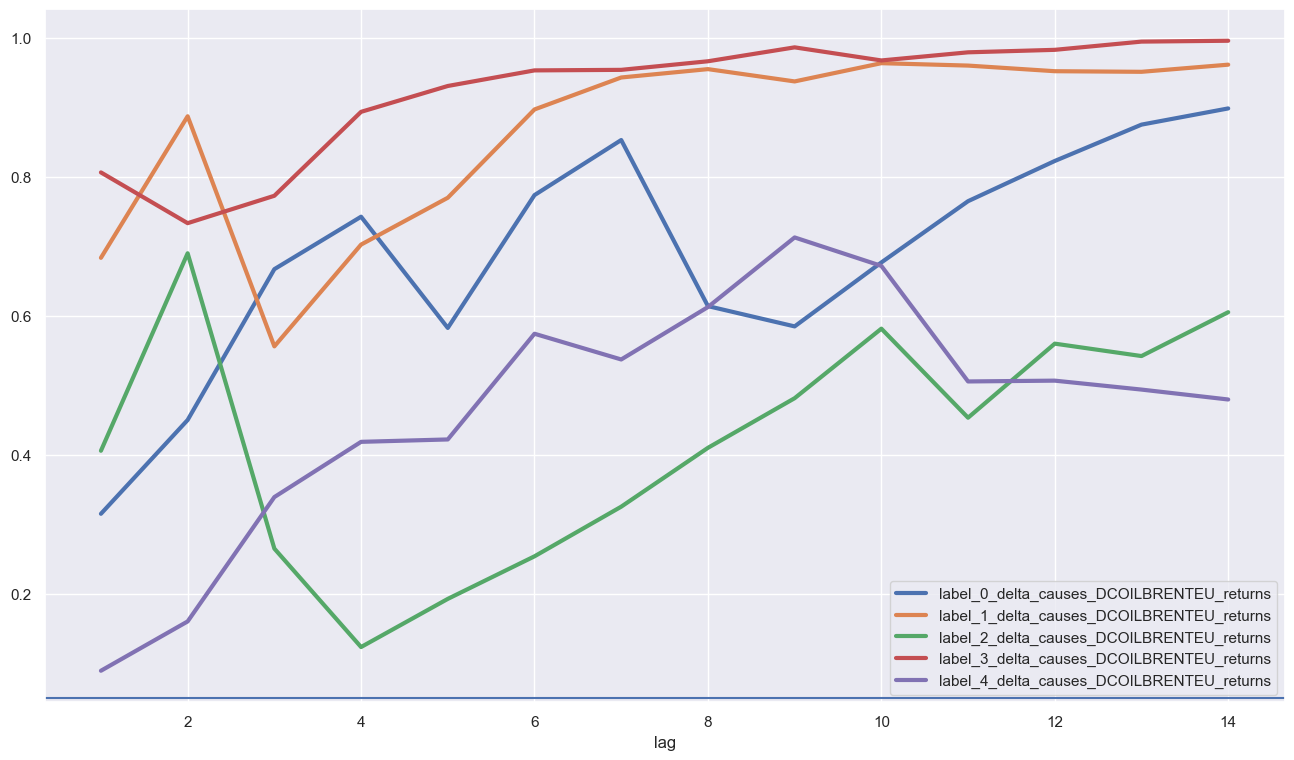

In [25]:
selected_target = 'DCOILBRENTEU_returns'
selected_features = [f'{col}_delta' for col in features_df.columns if col.startswith('label')]
# selected_features = features_df.columns

check_granger_causality(model_df, selected_target, selected_features, 14)

In [29]:
from statsmodels.tsa.api import VAR

model_df = df[['DCOILBRENTEU_returns', 'sentiment_score_0_delta', 'sentiment_score_1_delta', 'sentiment_score_2_delta', 'sentiment_score_3_delta', 'sentiment_score_4_delta']]
model_df.dropna(inplace=True)

model = VAR(model_df)
maxlag = 7

for i in range(1,maxlag+1):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  17.7830138081429
BIC :  18.153510708246277
FPE :  52853100.82207795
HQIC:  17.92876392095305 

Lag Order = 2
AIC :  17.898967816426254
BIC :  18.588144731717573
FPE :  59355331.07656464
HQIC:  18.170107872813453 

Lag Order = 3
AIC :  17.995237984467963
BIC :  19.00412650387708
FPE :  65365437.49436784
HQIC:  18.392196236274124 

Lag Order = 4
AIC :  18.070419755272248
BIC :  19.400057029604824
FPE :  70493462.86978248
HQIC:  18.593626802210753 

Lag Order = 5
AIC :  17.988926854364244
BIC :  19.640355637932583
FPE :  65013141.25730391
HQIC:  18.638815661647506 

Lag Order = 6
AIC :  18.128091707039935
BIC :  20.102360399692067
FPE :  74783027.6781193
HQIC:  18.9050976231747 

Lag Order = 7
AIC :  18.25042161296712
BIC :  20.548584302518815
FPE :  84613213.03830417
HQIC:  19.15498238771953 



/var/folders/vs/w5gtl8px5sxd5ywdly3_3yxh0000gn/T/ipykernel_37659/1028940965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [30]:
results = model.fit(maxlags=7, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Jul, 2024
Time:                     10:43:16
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    18.1535
Nobs:                     471.000    HQIC:                   17.9288
Log likelihood:          -8155.82    FPE:                5.28531e+07
AIC:                      17.7830    Det(Omega_mle):     4.83758e+07
--------------------------------------------------------------------
Results for equation DCOILBRENTEU_returns
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -0.000564         0.000973           -0.580           0.562
L1.DCOILBRENTEU_returns            0.044101         0.046270            0.953          

In [31]:
# Select the optimal lag order
lag_order_selection = model.select_order(maxlags=7)
print(lag_order_selection.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       18.57       18.63   1.164e+08       18.59
1      17.84*      18.21*  5.584e+07*      17.99*
2       17.95       18.64   6.228e+07       18.22
3       18.03       19.05   6.791e+07       18.43
4       18.10       19.44   7.286e+07       18.63
5       18.01       19.67   6.662e+07       18.67
6       18.14       20.12   7.551e+07       18.92
7       18.25       20.55   8.461e+07       19.15
-------------------------------------------------


In [32]:
model_df.head()

lags = range(1, 3)  # Just two lags for demonstration.

model_df = model_df.assign(**{
                f'{col} (t-{lag})': model_df[col].shift(lag)
                for lag in lags
                for col in model_df.columns[1:]
            })

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ARIMA
from sklearn.base import BaseEstimator, RegressorMixin
# import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor


In [34]:
# Sort data by date
model_df.dropna(inplace=True)
model_df = model_df.sort_values('date')

# Split the data
train_set, test_set= np.split(model_df, [int(.67 *len(model_df))])
X_train, y_train = train_set.iloc[:, 1:], train_set.iloc[:, 0] 
X_test, y_test = test_set.iloc[:, 1:], test_set.iloc[:, 0] 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [35]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [36]:
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

In [37]:
# For ARIMA, we need a time series dataset. Here we'll use y directly as a placeholder.
arima = ARIMA(y_train, order=(5,1,0))
arima_fit = arima.fit()
y_pred_arima = arima_fit.forecast(steps=len(y_test))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarnin

In [38]:
# ARIMAX requires the statsmodels library's SARIMAX implementation.
from statsmodels.tsa.statespace.sarimax import SARIMAX

arimax = SARIMAX(y_train, exog=X_train, order=(5,1,0))
arimax_fit = arimax.fit(disp=False)
y_pred_arimax = arimax_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is ava

In [39]:
ada = AdaBoostRegressor(n_estimators=50, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

In [40]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

models = {
    "Random Forest": y_pred_rf,
    "SVR": y_pred_svr,
    "ARIMA": y_pred_arima,
    "ARIMAX": y_pred_arimax,
    # "SVR-Li": y_pred_svr_li,
    "AdaBoost": y_pred_ada
}

for name, y_pred in models.items():
    mse, mae, r2 = evaluate_model(y_test, y_pred)
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Random Forest - MSE: 0.0003, MAE: 0.0143, R2: 0.0060
SVR - MSE: 0.0004, MAE: 0.0157, R2: -0.2437
ARIMA - MSE: 0.0004, MAE: 0.0165, R2: -0.3605
ARIMAX - MSE: 0.0005, MAE: 0.0169, R2: -0.4255
AdaBoost - MSE: 0.0004, MAE: 0.0156, R2: -0.2779


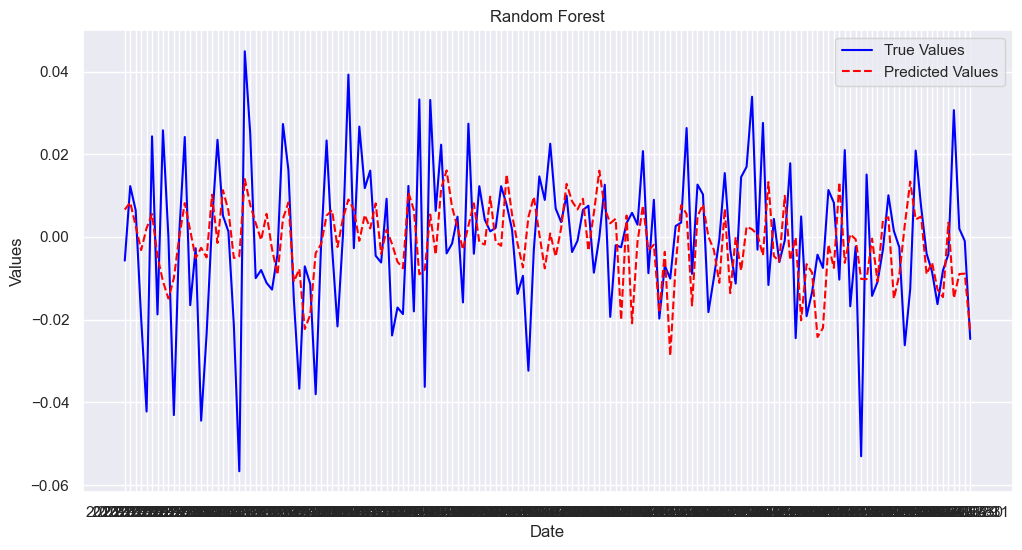

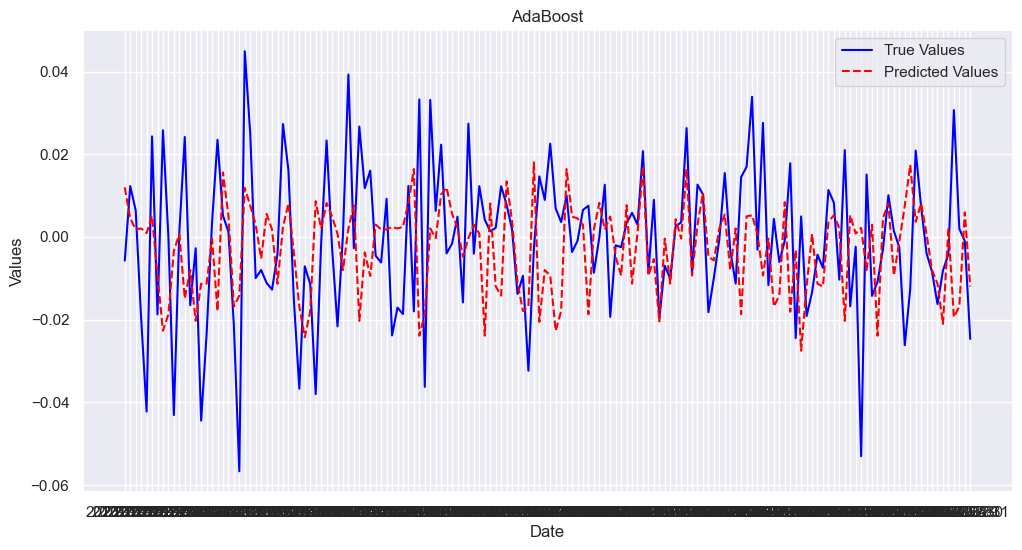

In [42]:
# Define a function to plot true vs. predicted values as line plots with a date index
def plot_true_vs_pred_line(dates, y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='True Values', color='blue')
    plt.plot(dates, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

y_test_dates = test_set.index

# Plotting the results for each model
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_rf, "Random Forest")
# plot_true_vs_pred_line(y_test_dates, y_test, y_pred_svr, "SVR")
# plot_true_vs_pred_line(y_test_dates, y_test, y_pred_arima, "ARIMA")
# plot_true_vs_pred_line(y_test_dates, y_test, y_pred_arimax, "ARIMAX")
# plot_true_vs_pred_line(y_test_dates, y_test, y_pred_svr_li, "SVR-Li")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_ada, "AdaBoost")


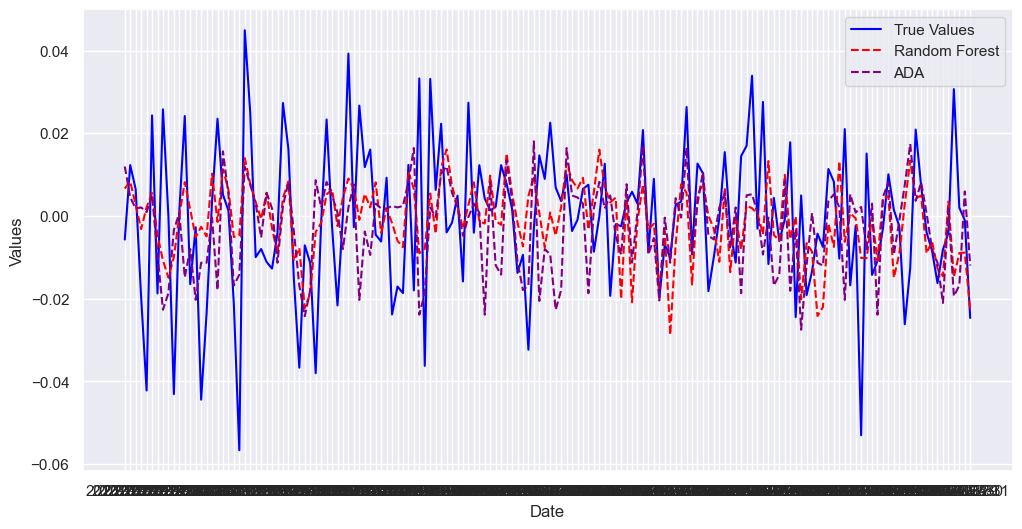

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test, label='True Values', color='blue')
plt.plot(y_test_dates, y_pred_rf, label='Random Forest', color='red', linestyle='--')
plt.plot(y_test_dates, y_pred_ada, label='ADA', color='purple', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
import joblib

joblib.dump(rf, "models/random_forest.joblib")
joblib.dump(svr, 'models/svr.joblib')
joblib.dump(arima, 'models/arima.joblib')
joblib.dump(arimax, 'models/arimax.joblib')
joblib.dump(ada, 'models/adaboost_model.joblib')

['models/adaboost_model.joblib']